In [1]:
from getdist import loadMCSamples,plots,MCSamples
import numpy as np
import matplotlib.pyplot as plt
import h5py
import emcee
from scipy.linalg import inv
from scipy.interpolate import CubicSpline

import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 24
mpl.rcParams['axes.labelsize'] = 30


%matplotlib inline


# read the data

In [2]:

def get_dict_from_hdf5(group, none_flag="NoneValue"):
    d = {}
    for key in group.keys():
        if isinstance(group[key], h5py.Group):
            d[key] = get_dict_from_hdf5(group[key], none_flag=none_flag)
        elif isinstance(group[key], h5py.Dataset):
            data = group[key][()]

            if np.array_equal(data, none_flag):
                d[key] = None
            else:
                d[key] = data
    return d

with h5py.File('w0wa_wbins_data.h5', 'r') as hf: 
    L = get_dict_from_hdf5(hf)

In [15]:
def print_dict_keys(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key))
        if isinstance(value, dict):
            print_dict_keys(value, indent + 1)
print_dict_keys(L)

cmb_desi1_panplus_bin13
  cov
  mean
  param_name
  z_knot
cmb_desi1_panplus_bin16
  cov
  mean
  param_name
  z_knot
cmb_desi1_panplus_bin19
  cov
  mean
  param_name
  z_knot
cmb_desi1_panplus_bin9
  cov
  mean
  param_name
  z_knot
cmb_desi1_panplus_w0wa
  cov
  mean
  param_name
cmb_desi2_desy5_bin19
  cov
  mean
  param_name
  z_knot
cmb_desi2_desy5_w0wa
  cov
  mean
  param_name
cmb_desi2_panplus_bin19
  cov
  mean
  param_name
  z_knot
cmb_desi2_panplus_w0wa
  cov
  mean
  param_name


In [3]:
def generate_gaussian_chains(mean,cov,names=['w0_fld','wa_fld'],labels=[r'w_0',r'w_a']):
    samps = np.random.multivariate_normal(mean, cov, size=10000)
    mcsamp = MCSamples(samples=samps,names=names,labels=labels)
    return mcsamp

In [4]:
# generate gauss samples for w0wa
cmb_desi1_panplus_w0wa = generate_gaussian_chains(L['cmb_desi1_panplus_w0wa']['mean'][:-1],
                                               L['cmb_desi1_panplus_w0wa']['cov'][:-1,:-1])
cmb_desi2_panplus_w0wa = generate_gaussian_chains(L['cmb_desi2_panplus_w0wa']['mean'][:-1],
                                               L['cmb_desi2_panplus_w0wa']['cov'][:-1,:-1])


cmb_desi2_desy5_w0wa_mean = L['cmb_desi2_desy5_w0wa']['mean'][:-1]
cmb_desi2_desy5_w0wa_cov = L['cmb_desi2_desy5_w0wa']['cov'][:-1,:-1]
cmb_desi2_desy5_w0wa = generate_gaussian_chains(cmb_desi2_desy5_w0wa_mean,
                                               cmb_desi2_desy5_w0wa_cov)

Removed no burn in
Removed no burn in
Removed no burn in


In [5]:
# the last 2 parameters are winf,Omega_m which are not used for reconstruction in this notebook.
# At high redshift we fix the equation of state to winf.
# winf is readed only for illustration and we use mean[:-1],cov[:-1,:-1] for reconstruction

last_wbin_index = -1

cmb_desi1_panplus_bin19_mean = L['cmb_desi1_panplus_bin19']['mean'][:last_wbin_index]
cmb_desi1_panplus_bin19_cov = L['cmb_desi1_panplus_bin19']['cov'][:last_wbin_index,:last_wbin_index]
cmb_desi1_panplus_bin19_zknot = L['cmb_desi1_panplus_bin19']['z_knot']

cmb_desi2_panplus_bin19_mean = L['cmb_desi2_panplus_bin19']['mean'][:last_wbin_index]
cmb_desi2_panplus_bin19_cov = L['cmb_desi2_panplus_bin19']['cov'][:last_wbin_index,:last_wbin_index]
cmb_desi2_panplus_bin19_zknot = L['cmb_desi2_panplus_bin19']['z_knot']


cmb_desi2_desy5_bin19_mean = L['cmb_desi2_desy5_bin19']['mean'][:last_wbin_index]
cmb_desi2_desy5_bin19_cov = L['cmb_desi2_desy5_bin19']['cov'][:last_wbin_index,:last_wbin_index]
cmb_desi2_desy5_bin19_zknot = L['cmb_desi2_desy5_bin19']['z_knot']

# the reconstructed history of w(z)

In [6]:
from scipy.interpolate import CubicSpline

z_arr = np.linspace(0,4,200)

def get_wz_from_wbins(mean,cov,zknot):
    size = 2000
    
    w_arr = np.zeros((size,z_arr.shape[0]))
    
    wbins = np.random.multivariate_normal(mean,
                                             cov, size=size)

    # add some more points to make sure Cubicspline give a smooth transformation to winf
    zbins_=np.append(zknot,[zknot[-1]+i for i in range(1,6)]) 
    for i in range(size):
        winf = wbins[i,-1]
        wbins_=np.append(wbins[i,:-1],[winf for i in range(1,6)])
        w_arr[i,:] = CubicSpline(zbins_,wbins_)(z_arr)
    return np.mean(w_arr,axis=0),np.std(w_arr,axis=0)

def get_wz_from_w0wa(mean,cov):
    size = 2000
    w_arr = np.zeros((size,z_arr.shape[0]))
    w0wa = np.random.multivariate_normal(mean,cov, size=size)


    w_arr = w0wa[:,0,None]+w0wa[:,1,None]*(1-1/(1+z_arr))
    return np.mean(w_arr,axis=0),np.std(w_arr,axis=0)
    


In [7]:
wmean_from_w0wa,werr_from_w0wa=get_wz_from_w0wa(cmb_desi2_desy5_w0wa_mean,
                   cmb_desi2_desy5_w0wa_cov)

In [8]:
wmean_from_wbins,werr_from_wbins=get_wz_from_wbins(cmb_desi2_desy5_bin19_mean,
                   cmb_desi2_desy5_bin19_cov,
                   cmb_desi2_desy5_bin19_zknot)

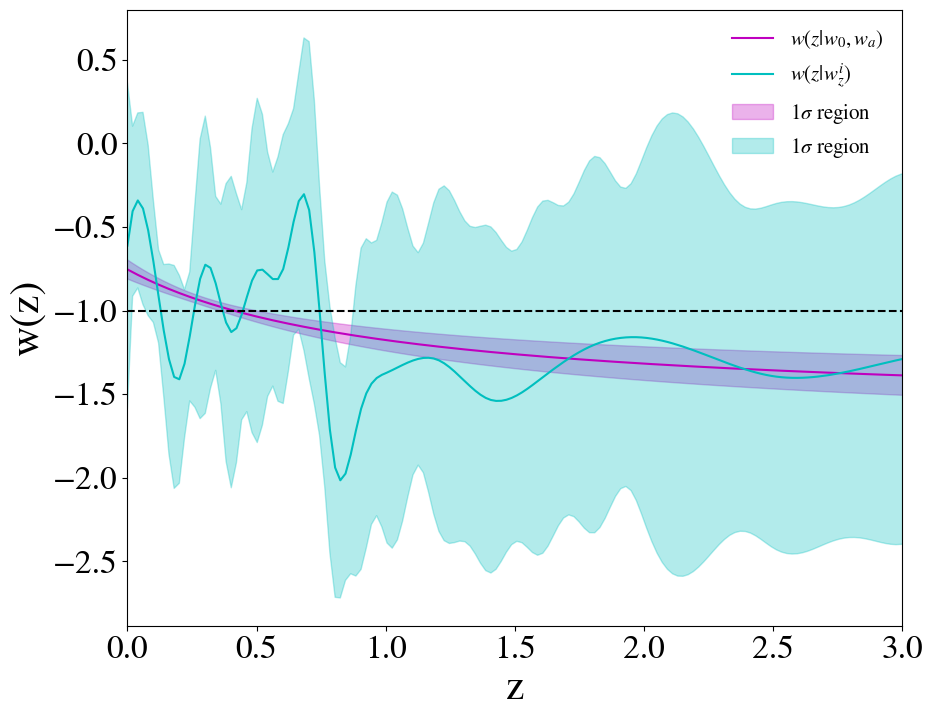

In [9]:
plt.figure(figsize=(10,8))
plt.plot(z_arr,wmean_from_w0wa,color='m',label=r'$w(z|w_0,w_a)$')
plt.plot(z_arr,wmean_from_wbins,color='c',label=r'$w(z|w_z^i)$')

plt.fill_between(z_arr,wmean_from_w0wa+werr_from_w0wa,
                 wmean_from_w0wa-werr_from_w0wa,alpha=0.3,color='m',label=r'$1\sigma$ region')

plt.fill_between(z_arr,wmean_from_wbins+werr_from_wbins,
                 wmean_from_wbins-werr_from_wbins,alpha=0.3,color='c',label=r'$1\sigma$ region')


plt.axhline(-1,color='k',linestyle='--')
plt.xlim(0,3)
#plt.legend()
plt.xlabel('z')
plt.ylabel('w(z)')
legend = plt.legend(fontsize=15)
legend.get_frame().set_linewidth(0)  # 设置边框线宽为0，即去掉边框

# Given wbins, can we recover w0wa?

## analytical

In [10]:
# see equation c4~c6 in 2503.04602
def project_psi_to_phi(c,psibar,z_at_transition):

    
    def get_w0wa(c,psibar,M):
        Sigma = inv((M.T).dot(inv(c)).dot(M))  #cov
        phibar = Sigma.dot(M.T).dot(inv(c)).dot(psibar)
        w0wa=np.random.multivariate_normal(phibar,Sigma,size=5000)
        w0wa_samp = MCSamples(samples=w0wa,names=['w0_fld','wa_fld'])
        return w0wa_samp
    
    ai = 1/(1+z_at_transition)
    M = np.array([[1,1-a_] for a_ in ai])   
    return get_w0wa(c,psibar,M)

w0wa_bin19_cmb_desi2_desy5_ana = project_psi_to_phi(cmb_desi2_desy5_bin19_cov[:-1,:-1],
                   cmb_desi2_desy5_bin19_mean[:-1],
                   cmb_desi2_desy5_bin19_zknot)




Removed no burn in


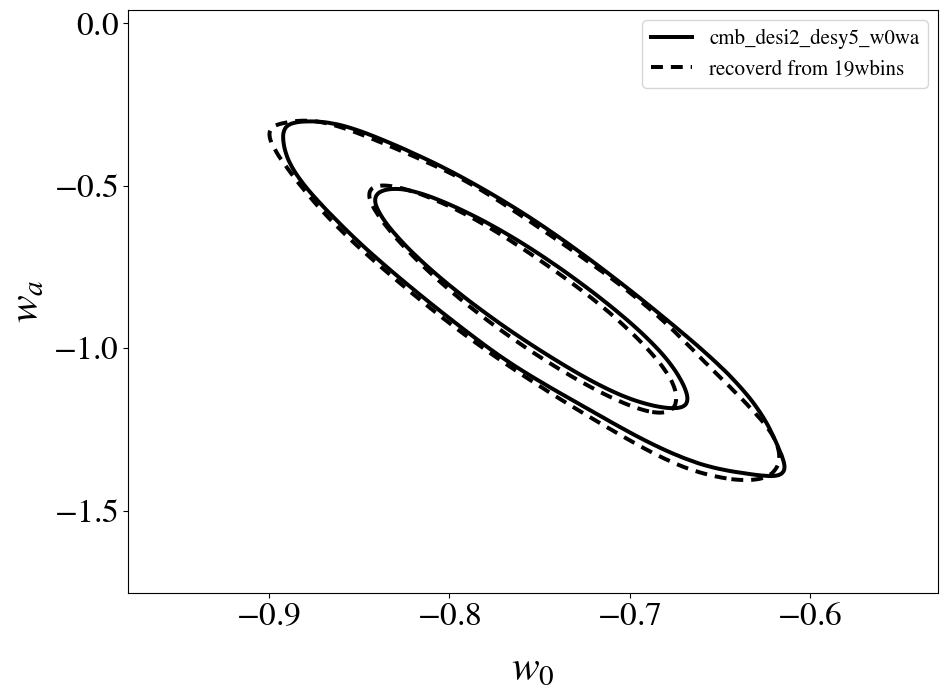

In [11]:
g = plots.get_single_plotter(width_inch=10,rc_sizes=True)
g.plot_2d([cmb_desi2_desy5_w0wa,
          w0wa_bin19_cmb_desi2_desy5_ana
          ],['w0_fld','wa_fld'],
          colors=['k','k'],
          ls=['-','--']
         )
g.add_legend([
             'cmb_desi2_desy5_w0wa',
    'recoverd from 19wbins'],fontsize=15)




## numerical

In [12]:


def sample_w0wa_from_wzi(mean,cov,z_knot):
    
    data_z = z_knot
    data_a = 1 / (1 + data_z)
    data_cov = cov
    data_mean = mean

    inv_cov = np.linalg.inv(data_cov)
    def loglkl(theta):
        w0,wa = theta
        w = w0 + wa * (1 - data_a)
        diff = w - data_mean
        return - 0.5 * diff @ inv_cov @ diff
    # MCMC setup
    ndim, nwalkers = 2, 10  # 2 parameters (w0, wa), 50 walkers
    initial_guess = [-1, 0]  # Example starting point
    pos = initial_guess + 0.5 * np.random.randn(nwalkers, ndim)  # Random initial positions

    # Initialize and run the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, loglkl)
    sampler.run_mcmc(pos, 20000, progress=True)

    # Get the samples
    emcee_samples = sampler.get_chain(discard=5000, thin=10, flat=True)
    
    emcee_samp = MCSamples(samples=emcee_samples,names=['w0_fld','wa_fld'],labels=[r'w_0',r'w_a'])
    return emcee_samp

In [13]:
# note the last parameter is Omega_m
w0wa_bin19_cmb_desi1_panplus = sample_w0wa_from_wzi(cmb_desi1_panplus_bin19_mean[:-1],
                                              cmb_desi1_panplus_bin19_cov[:-1,:-1],
                                                 cmb_desi1_panplus_bin19_zknot)

w0wa_bin19_cmb_desi2_panplus = sample_w0wa_from_wzi(cmb_desi2_panplus_bin19_mean[:-1],
                                                   cmb_desi2_panplus_bin19_cov[:-1,:-1],
                                                   cmb_desi2_panplus_bin19_zknot)

w0wa_bin19_cmb_desi2_desy5 = sample_w0wa_from_wzi(cmb_desi2_desy5_bin19_mean[:-1],
                                                 cmb_desi2_desy5_bin19_cov[:-1,:-1],
                                                 cmb_desi2_desy5_bin19_zknot)

100%|███████████████████████████████████| 20000/20000 [00:13<00:00, 1533.43it/s]


Removed no burn in


100%|███████████████████████████████████| 20000/20000 [00:11<00:00, 1709.00it/s]


Removed no burn in


100%|███████████████████████████████████| 20000/20000 [00:11<00:00, 1742.90it/s]

Removed no burn in


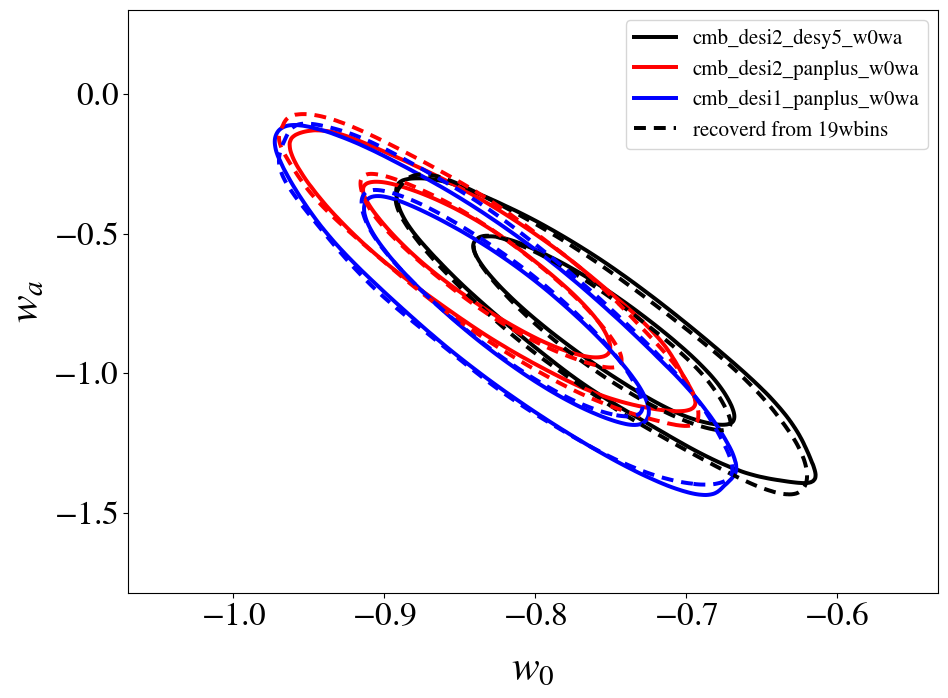

In [14]:
g = plots.get_single_plotter(width_inch=10,rc_sizes=True)
g.plot_2d([cmb_desi2_desy5_w0wa,
           cmb_desi2_panplus_w0wa,
           cmb_desi1_panplus_w0wa,
          w0wa_bin19_cmb_desi2_desy5,
          w0wa_bin19_cmb_desi2_panplus,
          w0wa_bin19_cmb_desi1_panplus],['w0_fld','wa_fld'],
          colors=['k','r','b','k','r','b'],
          ls=['-','-','-','--','--','--']
         )
#g.add_legend(['MCMC w0wa','19'])
g.add_legend(['cmb_desi2_desy5_w0wa',
              'cmb_desi2_panplus_w0wa',
                'cmb_desi1_panplus_w0wa',
                'recoverd from 19wbins'],fontsize=15)


